# Parallel optimization

Iaroslav Shcherbatyi, May 2017.

In [29]:
import numpy as np
np.random.seed(0)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

## Problem statement

In many practical cases, you can run evaluations of your objective in parallel, which you would be 
great to leverage in order to speed up the black box optimization. 
 
Think about it like this: if you want to find a perfect mix of ingredients for a perfect cookie, you would rather 
bake a batch of cookies with different ingredients rather then just a single cookie at a time. 
You can expect that the former is faster, as more cookies(points) are evaluated per unit of time. 

## Scikit-optimize approach to parallelization 

For parallel optimization, please use the "ask and tell" interface of scikit-optimize implemented as the `skopt.Optimizer` class.
You can provide the `n_points` property to the `ask` method of this class, which will return n points for you to
evaluate in parallel. Consider a simple example below. 

In [30]:
from sklearn.externals.joblib import Parallel, delayed
from skopt.space import Real
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer

# just a normal optimizer instantiation 
optimizer = Optimizer(
    base_estimator=ExtraTreesRegressor(),
    dimensions=[Real(-3.0, 3.0) for i in range(3)],
    acq_optimizer='sampling'
)

x = optimizer.ask(n_points=2, parallel_strategy='cl_min')

print(x)

[[0.29288102356394896, 1.2911361982345175, 0.61658025642986392], [0.26929909798138185, -0.45807120396657153, 0.87536467839993737]]


With `n_points=2`, the result of ask method is a list of two points for you to evaluate. You can use for example the joblib package to evaluate these points in parallel like so:

`Parallel()(delayed(objective)(v) for v in x)`

You can also specify different strategies that skopt can use to generate n points to evaluate in parallel. Currently the "minimum constant liar" strategy is used; You can see how it works by following the link at the bottom of this notebook. You can see the list of supported strategies in the definition of the `ask` method. 

FYI: points in the output of ask will always be different, and if they are not, please report this as an issue. Notice also that if you set `n_points=1`, then ask will also return a list, but with a single point to evaluate.

Lets compare a sequential mode of optimization with `n_points=1` to a parallel mode. For this, lets write a function that plots results of optimization at every sequential step:


In [34]:
# objective function to minimze
def objective(x):
    return np.sum(np.array(x) ** 2)

def plot_optimization(n_jobs):
    optimizer = Optimizer(
        base_estimator=ExtraTreesRegressor(),
        dimensions=[Real(-3.0, 3.0) for i in range(3)],
        acq_optimizer='sampling'
    )

    # configure number of workers to be used in parallel, and overall # of computations
    n_steps, Y = 20, []

    for i in range(n_steps):
        x = optimizer.ask(n_points=n_jobs)
        # evaluate n_points in parallel
        y = Parallel()(delayed(objective)(v) for v in x)
        # tell points and corresponding objectives to the optimizer
        optimizer.tell(x, y)
        # keep objectives history
        Y.append(min(optimizer.yi))
    
    # plot results of optimization 
    plt.plot(range(len(Y)), Y, label="points=" + str(n_jobs))

Now lets use the function and see how sequential mode performs against the parallel mode:

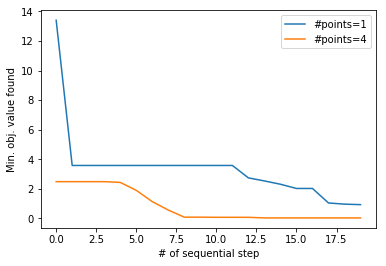

In [32]:
plot_optimization(1)
plot_optimization(4)
plt.xlabel("# of sequential step")
plt.ylabel("Min. obj. value found")
plt.legend()
plt.show()

You can see that parallel computation outperforms the sequential computation. Keep in mind that in some cases sequential optimization can outperform parallel initially if it gets a better initialization. You can run this example with different seeds to see more curves.

For further details, refer to [https://hal.archives-ouvertes.fr/hal-00732512/document](https://hal.archives-ouvertes.fr/hal-00732512/document) .